In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import geopandas as gpd
from shapely.geometry import Point
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import  StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans

In [2]:
def cm_plot(model,y_test, y_pred, encoder):

    labels=encoder.classes_
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=labels, yticklabels=labels)    
    plt.title(f"Confusion Matrix: {model}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [3]:
df=pd.read_csv('./df.csv')
df.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,year,time_of_day
0,101750280,35,1533640800,1533642900,33.748920,-118.275192,33.748920,-118.275192,6530.0,1.0,Round Trip,Walk-up,4127,4127,2018,Morning
1,46560345,32,1505670660,1505672580,34.035679,-118.270813,34.047749,-118.243172,6683.0,0.0,One Way,Walk-up,3057,3062,2017,Evening
2,120016336,6,1555924920,1555925280,34.046070,-118.233093,34.047749,-118.243172,6710.0,30.0,One Way,Monthly Pass,3022,3062,2019,Morning
3,129547190,138,1569151620,1569159900,34.062580,-118.290092,34.059689,-118.294662,17068.0,1.0,One Way,One Day Pass,4304,4311,2019,Morning
4,136619463,14,1580490660,1580491500,34.026291,-118.277687,34.021660,-118.278687,18841.0,30.0,One Way,Monthly Pass,4266,4443,2020,Evening


In [4]:
df_sample = df.sample(frac=0.15, random_state=7)
X=df_sample.drop(columns=['trip_id','plan_duration','passholder_type', 'bike_id', 'time_of_day','year' ])
y=df_sample['passholder_type']
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("LabelEncoder class mapping:", dict(zip(encoder.classes_, range(len(encoder.classes_)))))
encoder2 = LabelEncoder()
X['trip_route_category'] = encoder2.fit_transform(X['trip_route_category'])
print("LabelEncoder class mapping:", dict(zip(encoder2.classes_, range(len(encoder.classes_)))))

X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.20, random_state=7)



LabelEncoder class mapping: {'Annual Pass': 0, 'Flex Pass': 1, 'Monthly Pass': 2, 'One Day Pass': 3, 'Walk-up': 4}
LabelEncoder class mapping: {'One Way': 0, 'Round Trip': 1}


Accuracy: 0.6977994868758635
              precision    recall  f1-score   support

           0       0.64      0.02      0.03      1003
           1       0.00      0.00      0.00       348
           2       0.70      0.94      0.80     11661
           3       0.60      0.02      0.04      1236
           4       0.69      0.52      0.59      6020

    accuracy                           0.70     20268
   macro avg       0.53      0.30      0.30     20268
weighted avg       0.68      0.70      0.64     20268



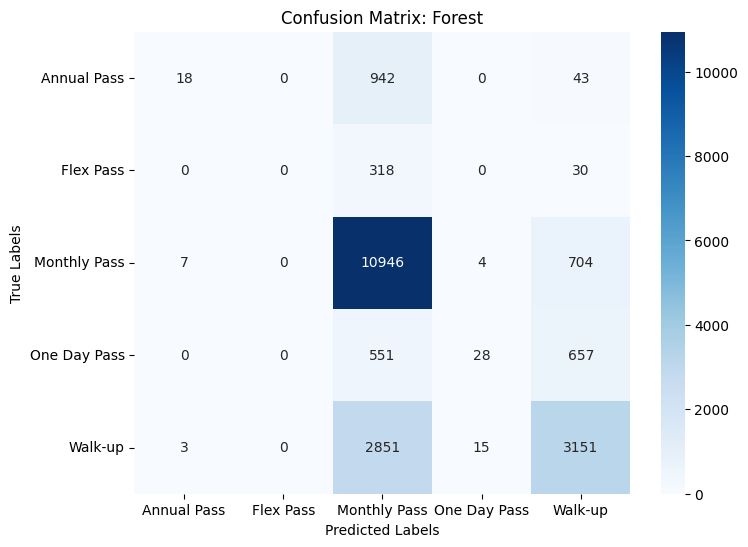

In [5]:
forest= RandomForestClassifier(n_estimators=100,max_depth=10, random_state=7)
forest.fit(X_train,y_train)
y_pred_forest = forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest, zero_division=0))
cm_plot('Forest', y_test, y_pred_forest,encoder)

Accuracy: 0.5674955595026643
              precision    recall  f1-score   support

           0       0.13      0.07      0.09      1003
           1       0.04      0.01      0.01       348
           2       0.63      0.80      0.71     11661
           3       0.21      0.08      0.11      1236
           4       0.46      0.32      0.38      6020

    accuracy                           0.57     20268
   macro avg       0.29      0.26      0.26     20268
weighted avg       0.52      0.57      0.53     20268



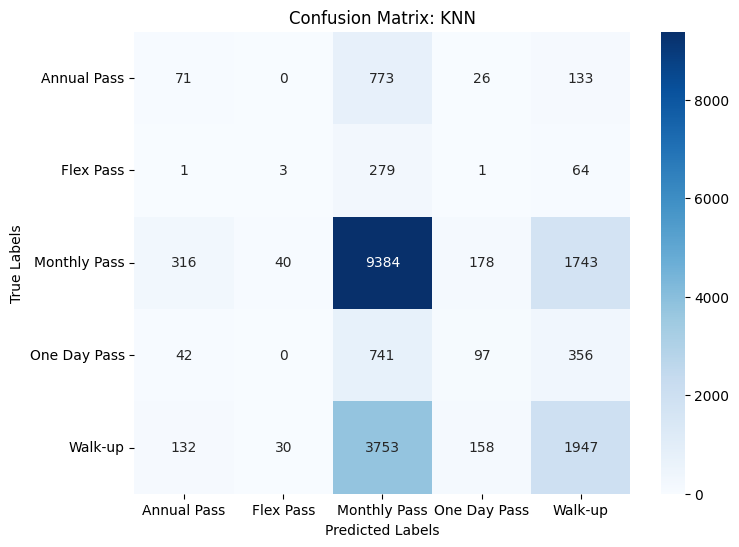

In [6]:
knn= KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, zero_division=0))
cm_plot('KNN', y_test, y_pred_knn,encoder)

Accuracy: 0.6887211367673179
              precision    recall  f1-score   support

           0       0.44      0.01      0.02      1003
           1       0.00      0.00      0.00       348
           2       0.70      0.92      0.80     11661
           3       0.40      0.04      0.07      1236
           4       0.65      0.53      0.58      6020

    accuracy                           0.69     20268
   macro avg       0.44      0.30      0.30     20268
weighted avg       0.65      0.69      0.64     20268



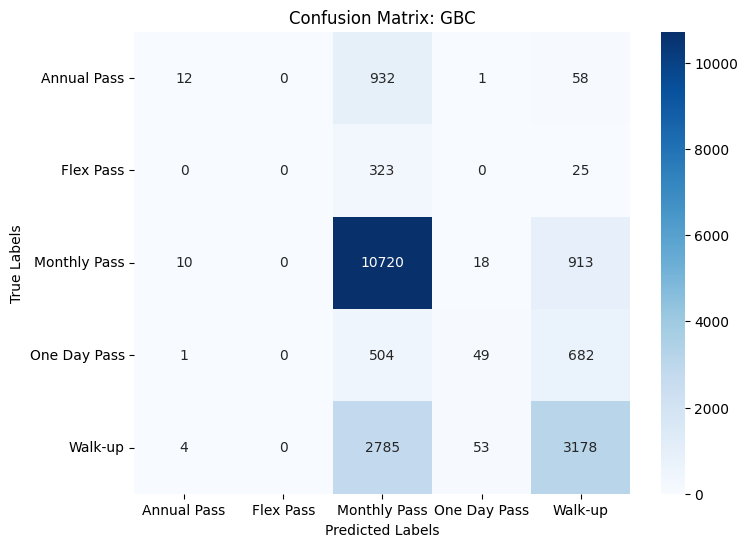

In [7]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))
print(classification_report(y_test, y_pred_gbc, zero_division=0))
cm_plot('GBC', y_test, y_pred_gbc,encoder)

Accuracy: 0.6570949279652655
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1003
           1       0.00      0.00      0.00       348
           2       0.66      0.93      0.77     11661
           3       0.00      0.00      0.00      1236
           4       0.64      0.41      0.50      6020

    accuracy                           0.66     20268
   macro avg       0.26      0.27      0.25     20268
weighted avg       0.57      0.66      0.59     20268



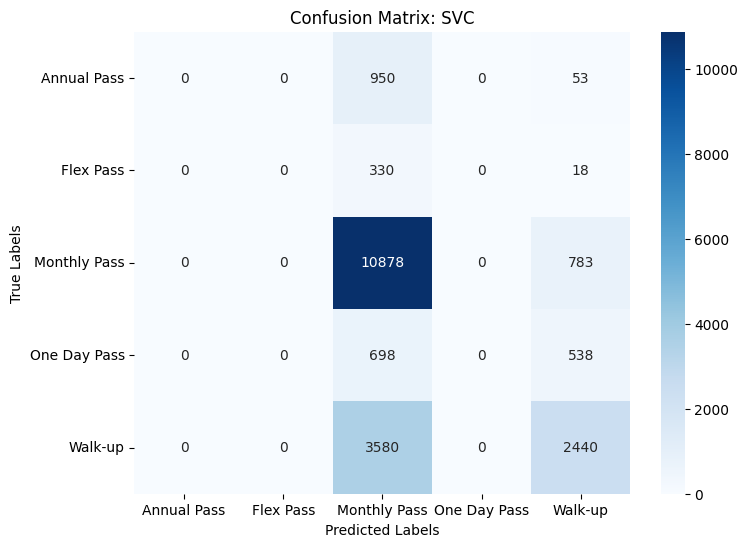

In [8]:
clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
cm_plot('SVC', y_test, y_pred,encoder)

[I 2025-02-04 19:38:12,435] A new study created in memory with name: GBC_tuning
[I 2025-02-04 19:38:44,259] Trial 0 finished with value: 0.6830965068087625 and parameters: {'n_estimators': 105, 'learning_rate': 0.07327626163727351, 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6830965068087625.
[I 2025-02-04 19:39:13,299] Trial 1 finished with value: 0.6856127886323268 and parameters: {'n_estimators': 95, 'learning_rate': 0.32549228666470986, 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.6856127886323268.
[I 2025-02-04 19:49:32,383] Trial 2 finished with value: 0.6940990724294455 and parameters: {'n_estimators': 288, 'learning_rate': 0.3561148187969322, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.6940990724294455.
[I 2025-02-04 19:59:46,575] Trial 3 finished with value: 0.6642490625616736 and parameters: {'n_estimators': 282, 'learning_rate':

Best Hyperparameters: {'n_estimators': 202, 'learning_rate': 0.09529953207379024, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 10}
Accuracy: 0.7145253601736727
              precision    recall  f1-score   support

           0       0.59      0.23      0.33      1003
           1       0.49      0.07      0.12       348
           2       0.74      0.90      0.81     11661
           3       0.43      0.17      0.24      1236
           4       0.68      0.59      0.63      6020

    accuracy                           0.71     20268
   macro avg       0.59      0.39      0.43     20268
weighted avg       0.69      0.71      0.69     20268



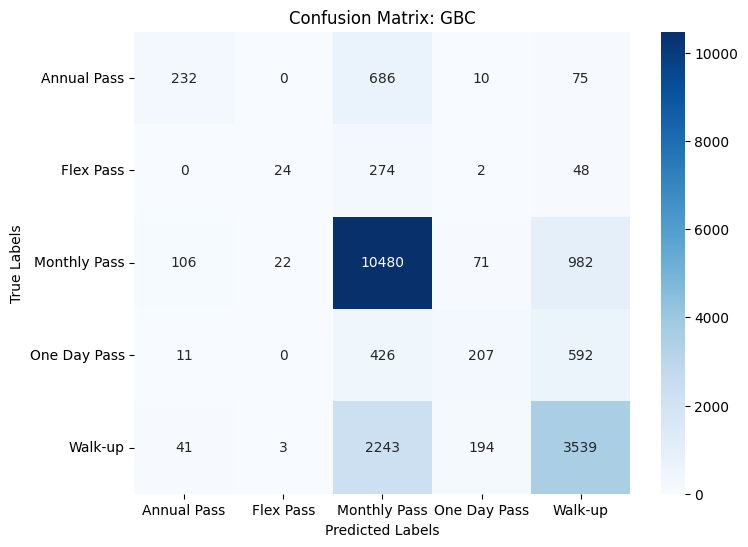

In [9]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    gbc = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    gbc.fit(X_train, y_train)
    
    y_pred_gbc = gbc.predict(X_test)
    return accuracy_score(y_test, y_pred_gbc)

study = optuna.create_study(direction='maximize', study_name='GBC_tuning')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

gbc = GradientBoostingClassifier(**best_params, random_state=42)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_gbc))
print(classification_report(y_test, y_pred_gbc))
cm_plot('GBC', y_test, y_pred_gbc, encoder)
